In [24]:
import numpy as np
import robustsp as rsp
import scipy
from scipy.stats.distributions import chi2
from scipy.io import loadmat
import numba

NR_ITER = 10000
p = 8 # dimension

# Matlab-like exp function for complex numbers
mExp = lambda c: np.exp(np.real(c))*\
        (np.cos(np.imag(c))\
         +1j*np.sin(np.imag(c)))

s = np.array([mExp(x) for x in 1j*np.arange(1,p+1)*np.pi]) # pulse of || p ||^2 = m

alpha = np.append(np.arange(0.001,0.04,0.002),0.04)
lam = 1 - alpha ** (1/(p-1)) # 1x21
nu = 0.5
nlist = [4*p,8*p,12*p] # number of secondary data
ntest = 10 # number of primary data

Pfa1 = np.zeros((len(nlist),len(alpha))) # 3 x 21
Pfa2 = np.zeros((len(nlist),len(alpha)))

Lambda1 = np.zeros((NR_ITER,ntest)) # 10_000 x 10
Lambda2 = np.zeros((NR_ITER,ntest))

np.random.seed(1) # for reproducibility

####################

for kk in range(len(nlist)):
    n = nlist[kk]
    for it in range(NR_ITER):
        # Generate Covariance matrix
        l = np.random.uniform(0.1,1,p) 
        #l = loadmat('l.mat',struct_as_record=False)['l'].ravel()
        # samples p number uniformly from [0.1,1[
        P = np.linalg.qr(np.random.rand(p,p)+
                        np.random.rand(p,p)*1j)[0] # the Q-matrix from QR decomposition
        # P is 8 x 8
        #P = loadmat('P.mat',struct_as_record=False)['P']

        sig = p*P@np.diag(l/np.sum(l,axis=0))@P.conj().T # 8 x 8
        sig.ravel()[np.arange(0,p**2,p+1)] = \
                            np.real(sig.ravel()[np.arange(0,p**2,p+1)]) 
        sqrsig = scipy.linalg.sqrtm(sig) # 8 x 8

        # Generate the secondary data and compute the covariance
        x0 = sqrsig*np.sqrt(0.5)@(np.random.randn(p,n)+
                                 1j*np.random.randn(p,n)) # ~ N_p(0,I)
        # 8 x 32
        #x0 = loadmat('x0.mat',struct_as_record=False)['x0']
        x = np.sqrt(np.random.gamma(nu,1/nu,n)) * x0 # 8 x 32
        #x = loadmat('x.mat',struct_as_record=False)['x']

        hsig1,_,_,_ = rsp.Mscat(x.conj().T,'t-loss',0) # Tylers M-estimator, 8x8
        hsig2,_,_,_ = rsp.Mscat(x.conj().T,'Huber',0.8) # Hubers M-estimator, 8x8

        B1 = scipy.linalg.sqrtm(np.linalg.pinv(hsig1)) #8x8
        B2 = scipy.linalg.sqrtm(np.linalg.pinv(hsig2)) #8x8

        # Generate primary data from C K_v(0,sig)
        z0 = sqrsig * np.sqrt(0.5)@(np.random.randn(p,ntest)+
                                   1j*np.random.randn(p,ntest)) # 8x10
        #z0 = loadmat('z0.mat',struct_as_record=False)['z0']
        z = np.sqrt(np.random.gamma(nu,1/nu,ntest)) * z0 # 8x10
        #z = loadmat('z.mat',struct_as_record=False)['z']

        # Compute the ADAPTIVE DETECTOR
        v1 = B1@z # 8x10
        q1 = B1@s[:,None] / scipy.linalg.norm(B1@s[:,None]) # 8x1

        v2 = B2@z
        q2 = B2@s[:,None] / scipy.linalg.norm(B2@s[:,None])

        v1 /= np.sqrt(np.sum(v1*np.conj(v1),axis=0))
        v2 /= np.sqrt(np.sum(v2*np.conj(v2),axis=0))

        Lambda1[it,:] = np.abs((v1.conj().T@q1).ravel())**2 # wrong
        Lambda2[it,:] = np.abs((v2.conj().T@q2).ravel())**2

        if (it+1)%250 == 0: print(' . ')

        print('\n')
        for al in range(len(alpha)):
            Pfa1[kk,al] = np.sum(Lambda1[:]>lam[al])/(NR_ITER*ntest)
            Pfa2[kk,al] = np.sum(Lambda2[:]>lam[al])/(NR_ITER*ntest)
                



















































































































































































































































































































































































































































































































 . 




















































































































































































































































































































































































































































































































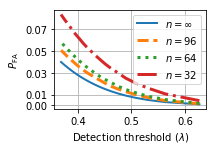

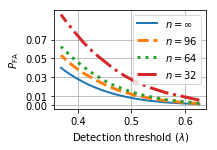

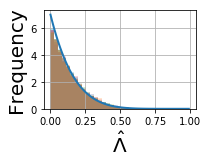

In [58]:
### Plots
import matplotlib.pyplot as plt

### Plot Threshold vs PFA

plt.subplot(221)
plt.plot(lam,alpha,linestyle='-',linewidth=2)
plt.plot(lam,Pfa1[2,:],'--',lam,Pfa1[1,:],':',lam,Pfa1[0,:],'-.',linewidth=3)
plt.yticks([0, 0.01, 0.03, 0.05, 0.07])
plt.ylabel('$P_{\mathrm{FA}}$')
plt.xlabel(r'Detection threshold $(\lambda)$')
plt.legend(('$n=\infty$','$n=96$','$n=64$','$n=32$'))
plt.grid()
plt.show()

plt.subplot(222)
plt.plot(lam,alpha,linestyle='-',linewidth=2)
plt.plot(lam,Pfa2[2,:],'--',lam,Pfa2[1,:],':',lam,Pfa2[0,:],'-.',linewidth=3)
plt.yticks([0, 0.01, 0.03, 0.05, 0.07])
plt.ylabel('$P_{\mathrm{FA}}$')
plt.xlabel(r'Detection threshold $(\lambda)$')
plt.legend(('$n=\infty$','$n=96$','$n=64$','$n=32$'))
plt.grid()
plt.show()

# Plot the histogram
from scipy.stats import beta
import matplotlib
matplotlib.font_manager._rebuild()
hfont = {'fontname':'Helvetica'}
plt.subplot(223)

#hist=plt.hist(Lambda1,bins=30,density=True)
plt.ylabel('Frequency',fontsize=20,**hfont)
plt.xlabel('$\hat \Lambda$',fontsize=20,**hfont)
plt.plot(np.arange(0,1,0.01),beta.pdf(np.arange(0,1,0.01),1,p-1),'-',linewidth=2)
plt.hist(Lambda1,bins=30, density=True,histtype='stepfilled', alpha=0.2)
plt.grid()
plt.show()

# Q-Q plot for Tyler's M-estimator for n = 96
lams = np.sort(Lambda1)
len 

In [25]:
Pfa1

array([[0.00439, 0.01053, 0.01595, 0.02064, 0.025  , 0.03003, 0.03398,
        0.03815, 0.04238, 0.04627, 0.0502 , 0.05376, 0.05743, 0.06136,
        0.06484, 0.06825, 0.0722 , 0.07558, 0.0788 , 0.08204, 0.08377],
       [0.00174, 0.00534, 0.00851, 0.01175, 0.01461, 0.01772, 0.021  ,
        0.02387, 0.0267 , 0.02964, 0.03261, 0.03532, 0.03808, 0.04096,
        0.04376, 0.04654, 0.0492 , 0.05184, 0.05442, 0.05706, 0.05829],
       [0.00146, 0.00436, 0.00722, 0.00994, 0.01263, 0.01509, 0.01757,
        0.02038, 0.02317, 0.02558, 0.02807, 0.03033, 0.03286, 0.03516,
        0.03775, 0.04031, 0.04261, 0.04499, 0.04744, 0.04975, 0.0508 ]])

In [7]:
Pfa1

array([[0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.1,
        0.1, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2],
       [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.1,
        0.1, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2],
       [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.1,
        0.1, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2]])

In [18]:
sig.ravel()[range(64)]=0
sig
np.sum(Lambda1[:]>lam[al])

0

In [5]:
Pfa1

array([[0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00,
        0.e+00, 0.e+00, 0.e+00, 0.e+00, 1.e-05, 1.e-05, 2.e-05, 2.e-05,
        2.e-05, 2.e-05, 2.e-05, 2.e-05, 2.e-05],
       [0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00,
        0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00,
        0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00],
       [0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00,
        0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00,
        0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00]])